<a href="https://colab.research.google.com/github/arunrajuamrutha/text-image-stable-diffusion/blob/main/p2_Stable_Diffusion_ProductSnapAI_Training_and_Inference_Martin_Valen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Part 2: Fine-tuning Stable Diffusion

To train stable diffusion on our images, we can use a technique called fine-tuning, which involves taking a pre-trained stable diffusion model and training it further on a new dataset. In this way, we can leverage the knowledge already learned by the pre-trained model and adapt it to the new dataset, allowing us to achieve better performance with less training time. In this context, we will be fine-tuning a stable diffusion model on our own images, which will enable us to generate new images that are similar in style and content to our original dataset. Once we have fine-tuned the model, we will be able to use it for inference, generating new images on demand.

In [ ]:
!cd /content/
!git clone https://github.com/huggingface/diffusers.git
!pip install ./diffusers
!pip install -U -r /content/diffusers/examples/text_to_image/requirements.txt

Cloning into 'diffusers'...
remote: Enumerating objects: 50014, done.
remote: Counting objects: 100% (3546/3546), done.
remote: Compressing objects: 100% (1319/1319), done.
remote: Total 50014 (delta 2503), reused 2820 (delta 1965), pack-reused 46468
Receiving objects: 100% (50014/50014), 31.86 MiB | 10.57 MiB/s, done.
Resolving deltas: 100% (36781/36781), done.
Processing ./diffusers
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for diffusers: filename=diffusers-0.24.0.dev0-py3-none-any.whl size=1729176 sha256=a0e9c2b9eb47867c037f3540b53238419fff15e7692c86ccace95b430a9fb516
  Stored in directory: /tmp/pip-ephem-wheel-cache-blei5r6v/wheels/95/c5/3b/e1b4269f8a2584de57e75f949a185b48fc4144e9a91fc9965a
Successfully built diffusers
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 90.1 MB/s eta 0:00:

In [ ]:
!pip install tensorboard==2.14

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 47.6 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.1
    Uninstalling tensorboard-2.15.1:
      Successfully uninstalled tensorboard-2.15.1


In [ ]:
!pip3 uninstall torch torchvision torchaudio -y

Found existing installation: torch 2.1.1
Uninstalling torch-2.1.1:
  Successfully uninstalled torch-2.1.1
Found existing installation: torchvision 0.16.1
Uninstalling torchvision-0.16.1:
  Successfully uninstalled torchvision-0.16.1
Found existing installation: torchaudio 2.1.0+cu118
Uninstalling torchaudio-2.1.0+cu118:
  Successfully uninstalled torchaudio-2.1.0+cu118


In [ ]:
!pip3 install torch==2.1.0 torchvision==0.16.0 torchaudio==2.1.0 --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 GB 900.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 63.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 27.2 MB/s eta 0:00:00


Let's configure HuggingFace Accelerate, a platform for allowing us to automatically configure our system to be able to run our training script. You can learn more about Accelerate [here](https://huggingface.co/docs/accelerate/index).

In [ ]:
!nvidia-smi

Tue Nov 28 17:57:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    41W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!accelerate config default --mixed_precision fp16

accelerate configuration saved at /root/.cache/huggingface/accelerate/default_config.yaml


Time to configure our environment variables. For this, we want to tell the script our model name, dataset name, and where we would like it to output the model. We will be automatically pushing the model directly to HuggingFace Hub which will require us to login to our HuggingFace account using the token provided through your HuggingFace account settings.

In [ ]:
import os

os.environ['MODEL_NAME'] = f'CompVis/stable-diffusion-v1-2'
os.environ['DATASET_NAME'] = f'arunrajuamrutha3/martin_valen_dataset_2'
os.environ['OUTPUT_DIR'] = f'sd_martin_valen-model-v1-2_400_demo_3'

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

Run our training script using HuggingFace accelerate. We'll be inputing our dataset and model with 400 steps (selected) and 134 epochs (default). The model will then be automatically pushed to the hub.

In [ ]:
!accelerate launch diffusers/examples/text_to_image/train_text_to_image.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --dataset_name=$DATASET_NAME \
  --use_ema \
  --resolution=512 --center_crop --random_flip \
  --train_batch_size=1 \
  --gradient_accumulation_steps=4 \
  --gradient_checkpointing \
  --mixed_precision="fp16" \
  --max_train_steps=400 \
  --learning_rate=1e-05 \
  --max_grad_norm=1 \
  --push_to_hub \
  --checkpointing_steps=100000 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --output_dir=$OUTPUT_DIR

2023-11-28 17:58:16.001371: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-28 17:58:16.001425: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-28 17:58:16.001469: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-28 17:58:17.235076: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
11/28/2023 17:58:17 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

scheduler/scheduler_config.json: 100% 288/288 [00:00<00:00, 1.68MB/s]
{

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

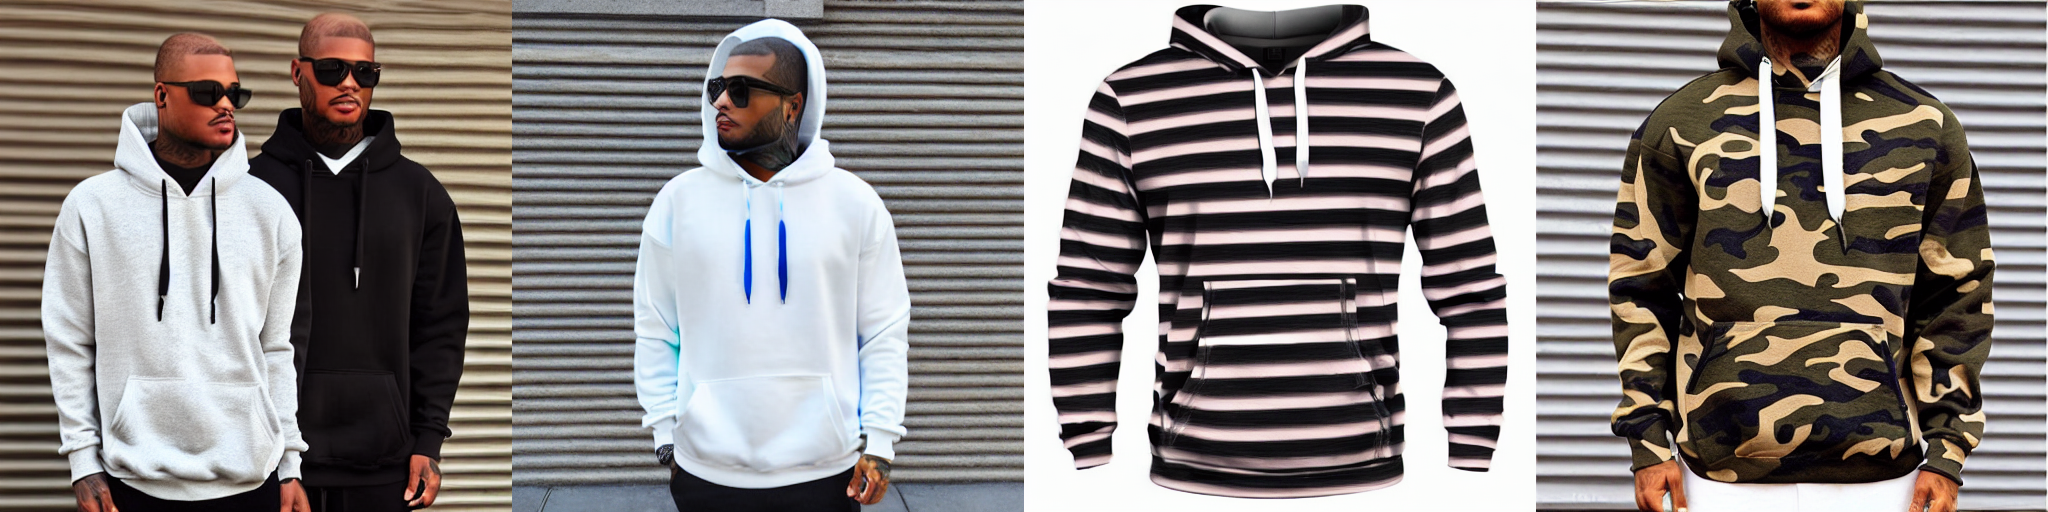

In [ ]:
# Stable Diffusion V1
from diffusers import StableDiffusionPipeline
import torch
from PIL import Image

model_path = "./sd_martin_valen-model-v1-2_400_demo_3"
pipe = StableDiffusionPipeline.from_pretrained(model_path, torch_dtype=torch.float16)
pipe.to("cuda")

# Run inference using ChatGPT prompts to acquire 4 image panels
image1 = pipe(prompt="black hoodie with a front half zipper by martin valen").images[0]
image1.save("ProductSnapAI_panel_1.png")

image2 = pipe(prompt="white hoodie with a blue design by martin valen").images[0]
image2.save("ProductSnapAI_panel_2.png")

image3 = pipe(prompt="stripped hoodie by martin valen").images[0]
image3.save("ProductSnapAI_panel_3.png")

image4 = pipe(prompt="camouflage hoodie by martin valen").images[0]
image4.save("ProductSnapAI_panel_4.png")

# Image grid helper function from HuggingFace
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

all_images = [image1, image2, image3, image4]
grid = image_grid(all_images, rows=1, cols=4)
grid

In [ ]:
!pip install huggingface_hub

In [ ]:
# prompt: push the model to the hugging face take model id as parameter

model_path = "./sd_martin_valen-model-v1-2_400_demo_3"
pipeline = StableDiffusionPipeline.from_pretrained(model_path, torch_dtype=torch.float16)
pipeline.to("cuda")
model_id = "arunrajuamrutha3/martin_valen_dataset_2_model_v1-2_400_demo_3"
pipeline.push_to_hub(model_id)


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/608M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

'https://huggingface.co/arunrajuamrutha3/martin_valen_dataset_2_model_v1-2_400_demo_3/tree/main/'

In [ ]:
!pip install clip

In [ ]:
model_ckpt = "arunrajuamrutha3/martin_valen_dataset_2_model_v1-2_400_demo_3"
sd_pipeline = StableDiffusionPipeline.from_pretrained(model_ckpt, torch_dtype=torch.float16).to("cuda")


model_index.json:   0%|          | 0.00/689 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

safety_checker/config.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/546 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/635 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/585 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/355 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/608M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.85k [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/672 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
prompts = [
    "white hoodie with a blue design by martin valen",
    "stripped hoodie by martin valen",
    "camouflage hoodie by martin valen"

]

In [ ]:
images = sd_pipeline(prompts, num_images_per_prompt=1, output_type="np").images

print(images.shape)

  0%|          | 0/50 [00:00<?, ?it/s]

(3, 512, 512, 3)


In [ ]:
from diffusers import StableDiffusionPipeline
import torch

In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 14.4 MB/s eta 0:00:00


In [ ]:
from torchmetrics.functional.multimodal import clip_score
from functools import partial

clip_score_fn = partial(clip_score, model_name_or_path="openai/clip-vit-base-patch16")

def calculate_clip_score(images, prompts):
    images_int = (images * 255).astype("uint8")
    clip_score = clip_score_fn(torch.from_numpy(images_int).permute(0, 3, 1, 2), prompts).detach()
    return round(float(clip_score), 4)

sd_clip_score = calculate_clip_score(images, prompts)
print(f"CLIP score: {sd_clip_score}")

config.json:   0%|          | 0.00/4.10k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/599M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

CLIP score: 31.9267
